In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# ... (outras importações)
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm # <-- ADICIONE ESTA LINHA

# --- 1. Configuração e Hiperparâmetros ---

# Mover para a GPU se estiver disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparâmetros
lr = 0.0002
batch_size = 128
image_size = 28  # Imagens do MNIST são 28x28
channels_img = 1 # Canal 1 (escala de cinza)
latent_dim = 100 # Dimensão do vetor de ruído (z)
n_epochs = 50

# --- 2. Carregar o Dataset (MNIST) ---

# O MNIST varia de 0 a 1. A saída do Gerador usará Tanh (-1 a 1).
# Portanto, normalizamos o dataset para o range [-1, 1].
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]), # (valor - 0.5) / 0.5
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- 3. Definir o Gerador (Generator) ---

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Entrada: (N, latent_dim, 1, 1)
            self._block(latent_dim, 256, 7, 1, 0), # (N, 256, 7, 7)
            self._block(256, 128, 4, 2, 1),       # (N, 128, 14, 14)
            self._block(128, 64, 4, 2, 1),        # (N, 64, 28, 28)

            # Camada final para gerar a imagem
            nn.ConvTranspose2d(
                64, img_channels, kernel_size=1, stride=1, padding=0
            ),
            nn.Tanh() # Normaliza a saída para [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# --- 4. Definir o Discriminador (Discriminator) ---

class Discriminator(nn.Module):
    def __init__(self, img_channels):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # Entrada: (N, img_channels, 28, 28)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1), # (N, 64, 14, 14)
            nn.LeakyReLU(0.2),

            self._block(64, 128, 4, 2, 1),   # (N, 128, 7, 7)
            self._block(128, 256, 7, 1, 0),  # (N, 256, 1, 1)

            # Camada final de classificação (real ou falso)
            nn.Conv2d(256, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid() # Probabilidade (0 a 1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1) # Achata a saída para (N, 1)

# --- 5. Inicializar Redes, Otimizadores e Perda ---

gen = Generator(latent_dim, channels_img).to(device)
disc = Discriminator(channels_img).to(device)

# Otimizadores Adam (bons para GANs)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Função de Perda: Binary Cross Entropy
criterion = nn.BCELoss()

# Labels (rótulos)
real_label = 1.0
fake_label = 0.0

print("Iniciando o Treinamento...")
epochs_bar = tqdm(range(n_epochs), desc="Progresso Total")

# --- 6. Loop de Treinamento ---

for epoch in epochs_bar:

    # 1. Envolver o dataloader com o tqdm para a barra da época
    #    'leave=False' faz a barra sumir após a época terminar (fica mais limpo)
    epoch_bar = tqdm(dataloader, desc=f"Época {epoch+1}/{n_epochs}", leave=False)

    for i, (real_imgs, _) in enumerate(epoch_bar):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ============================================
        # ===      TREINAR O DISCRIMINADOR (D)     ===
        # ============================================
        opt_disc.zero_grad()

        # --- 1. Treinar com imagens REAIS ---
        labels_real = torch.full((batch_size, 1), real_label, device=device)
        output_real = disc(real_imgs)
        loss_D_real = criterion(output_real, labels_real)
        loss_D_real.backward()

        # --- 2. Treinar com imagens FALSAS ---
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = gen(noise)

        labels_fake = torch.full((batch_size, 1), fake_label, device=device)
        output_fake = disc(fake_imgs.detach())
        loss_D_fake = criterion(output_fake, labels_fake)
        loss_D_fake.backward()

        loss_D = loss_D_real + loss_D_fake
        opt_disc.step()

        # ============================================
        # ===       TREINAR O GERADOR (G)          ===
        # ============================================
        opt_gen.zero_grad()

        output_G = disc(fake_imgs)
        loss_G = criterion(output_G, labels_real)
        loss_G.backward()
        opt_gen.step()

        # ============================================
        # ===     ATUALIZAR A BARRA DE PROCESSO    ===
        # ============================================

        # 2. Remover o 'print' antigo e usar .set_postfix()
        # Isso atualiza a barra com as perdas atuais
        epoch_bar.set_postfix(Loss_D=f"{loss_D.item():.4f}",
                              Loss_G=f"{loss_G.item():.4f}")

print("Treinamento Concluído.")

Iniciando o Treinamento...


Progresso Total:   0%|          | 0/50 [00:00<?, ?it/s]

Época 1/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 2/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 3/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 4/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 5/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 6/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 7/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 8/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 9/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 10/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 11/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 12/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 13/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 14/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 15/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 16/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 17/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 18/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 19/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 20/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 21/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 22/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 23/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 24/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 25/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 26/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 27/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 28/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 29/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 30/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 31/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 32/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 33/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 34/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 35/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 36/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 37/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 38/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 39/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 40/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 41/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 42/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 43/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 44/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 45/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 46/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 47/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 48/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 49/50:   0%|          | 0/469 [00:00<?, ?it/s]

Época 50/50:   0%|          | 0/469 [00:00<?, ?it/s]

Treinamento Concluído.


##Salvando GAN

In [4]:
torch.save(gen.state_dict(), "generator_mnist.pth")
print("Modelo do Gerador salvo como generator_mnist.pth")

Modelo do Gerador salvo como generator_mnist.pth


##Visualizando resultados

Modelo do Gerador carregado com sucesso de 'generator_mnist.pth'


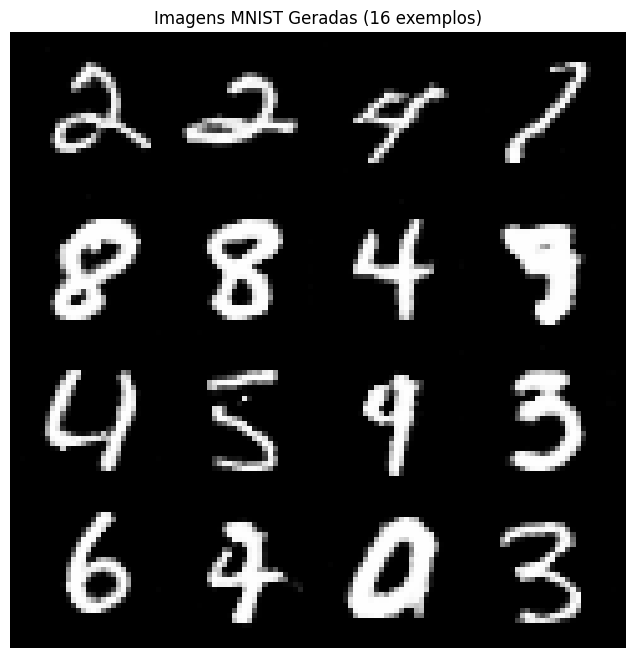

Grade de imagens geradas salva como generated_mnist_grid.png


In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Configuração e Hiperparâmetros (DEVEM SER IGUAIS AO TREINAMENTO) ---

# Mover para a GPU se estiver disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparâmetros usados no treinamento
latent_dim = 100 # Dimensão do vetor de ruído (z)
channels_img = 1 # Canal 1 (escala de cinza)
image_size = 28 # Imagens do MNIST são 28x28

# --- 2. Definir a Arquitetura do Gerador (DEVE SER IDÊNTICA AO TREINAMENTO) ---
# A arquitetura precisa ser recriada para carregar os pesos

class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Entrada: (N, latent_dim, 1, 1)
            self._block(latent_dim, 256, 7, 1, 0), # (N, 256, 7, 7)
            self._block(256, 128, 4, 2, 1),       # (N, 128, 14, 14)
            self._block(128, 64, 4, 2, 1),        # (N, 64, 28, 28)

            # Camada final para gerar a imagem
            nn.ConvTranspose2d(
                64, img_channels, kernel_size=1, stride=1, padding=0
            ),
            nn.Tanh() # Normaliza a saída para [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# --- 3. Carregar o Modelo Gerador ---

# Caminho para o modelo salvo
MODEL_PATH = "generator_mnist.pth"

# Instanciar o Gerador com a arquitetura correta
gen = Generator(latent_dim, channels_img).to(device)

# Carregar os pesos (state_dict)
try:
    gen.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    gen.eval() # Colocar o modelo em modo de avaliação (desativa dropout, batchnorm, etc.)
    print(f"Modelo do Gerador carregado com sucesso de '{MODEL_PATH}'")
except FileNotFoundError:
    print(f"ERRO: O arquivo do modelo '{MODEL_PATH}' não foi encontrado.")
    print("Certifique-se de que você treinou o modelo e o salvou corretamente.")
    exit()

# --- 4. Gerar Novas Imagens ---

num_images_to_generate = 16 # Número de imagens para mostrar em uma grade
noise = torch.randn(num_images_to_generate, latent_dim, 1, 1, device=device)

with torch.no_grad(): # Não precisamos calcular gradientes para inferência
    generated_images = gen(noise).cpu() # Mover para CPU para visualização

# Desnormalizar as imagens (de [-1, 1] para [0, 1])
generated_images = (generated_images + 1) / 2.0

# --- 5. Visualizar as Imagens ---

# Usar torchvision.utils.make_grid para criar uma grade de imagens
grid = torchvision.utils.make_grid(generated_images, nrow=4, normalize=True)

# Converter o tensor da grade para uma imagem PIL/numpy para exibição
# Permute as dimensões para (altura, largura, canais)
np_grid = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np_grid, cmap='gray' if channels_img == 1 else None)
plt.axis("off")
plt.title(f"Imagens MNIST Geradas ({num_images_to_generate} exemplos)")
plt.show()

# Opcional: Salvar a grade de imagens
torchvision.utils.save_image(grid, "generated_mnist_grid.png")
print("Grade de imagens geradas salva como generated_mnist_grid.png")